# Simulating custom pulses

### Imports and settings

In [5]:
import sys

sys.path.append("../")
import pulse_simulator as ps

/Users/epelaezc/Desktop/Research/pulse-simulator/.venv/lib/python3.11/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


In [6]:
import numpy as np
from scipy import integrate, linalg

import csv
import functools
import qiskit as qk
import qiskit_dynamics as qk_d
import qiskit.quantum_info as qk_qi
import qiskit.providers.fake_provider as qk_fp
import matplotlib.pyplot as plt
from qiskit.circuit.library import XGate, SXGate, IGate

In [7]:
import matplotlib.pyplot as plt

In [8]:
# configure jax to use 64 bit mode
import jax

jax.config.update("jax_enable_x64", True)

# tell JAX we are using CPU
jax.config.update("jax_platform_name", "cpu")

# set default backend
qk_d.array.Array.set_default_backend("jax")
qk_d.array.Array.default_backend()

'jax'

In [9]:
backend = qk_fp.FakeManila()
units = 1e9
ns = units

dt = backend.configuration().dt * ns
n_steps = 50
duration = n_steps * dt  # \approx 10 ns
dt, duration

(0.2222222222222222, 11.11111111111111)

### Retrieve saved pulses

In [10]:
file_name = "../pico-pulses/saved-pulses-2023-12-13/a_single_qubit_gateset_R1e-3.csv"
gates = []

saved_dt = 2/9

with open(file_name) as file:
    reader = csv.reader(file)
    for row in reader:
        gates.append(np.array([float(x) for x in row]))

Rescale pulses so that their integral remains the same when changing `dt`.

In [11]:
expected = np.trapz(gates[0], dx=0.2)
expected

4.242121799056372

In [12]:
normalization = np.trapz(gates[0], dx=dt) / expected
normalization

1.111111111111111

In [13]:
normalized_pulse = gates[0] / normalization
np.trapz(normalized_pulse, dx=dt)

4.242121799056372

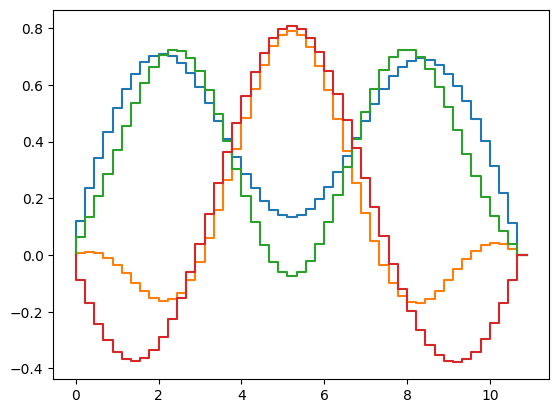

In [14]:
fig, ax = plt.subplots()
original_ts = np.arange(0, 50 * saved_dt, saved_dt)
for gate in gates:
    ax.step(original_ts, gate)

### Construct a solver

In [15]:
registers = [0]
config_vars = ps.backend_simulation_vars(backend, rabi=False, units=units)

H_rx = functools.partial(
    ps.rx_model,
    registers=registers,
    backend=backend,
    variables=config_vars,
    rotating_frame=False,
)

Hs_control = []
Hs_channels = []
for qubit in range(1):
    Hj_drift, Hjs_control, Hjs_channel = H_rx(qubit)
    Hs_control += Hjs_control
    Hs_channels += Hjs_channel


solver = qk_d.Solver(
    static_hamiltonian=None,
    hamiltonian_operators=[np.array([[0, 1], [1, 0]])],
    static_dissipators=None,
    rotating_frame=None,
    rwa_cutoff_freq=None,
    hamiltonian_channels=Hs_channels,
    channel_carrier_freqs={ch: 0.0 for ch in Hs_channels},
    dt=dt,
)

In [16]:
Hs_control

[Operator([[0.+0.j, 1.+0.j],
           [1.+0.j, 0.+0.j]],
          input_dims=(2,), output_dims=(2,))]

In [17]:
def get_pulse_unitary(pulse_array, duration, dt, solver, expected=None):
    duration = duration * dt
    
    # rescale pulse if needed
    if not np.isclose(saved_dt, dt): # WARNING: Global variable
        if expected is None:
            expected = integrate.simpson(pulse_array, dx=saved_dt)  
        normalization = integrate.simpson(pulse_array, dx=dt) / expected
        pulse_array = pulse_array / normalization

    # construct pulse and pulse moment
    pulse = qk.pulse.Waveform(pulse_array, limit_amplitude=False)
    with qk.pulse.build() as pulse_moment:
        channel = qk.pulse.DriveChannel(0)
        qk.pulse.play(pulse, channel)

    U0 = ps.qiskit_identity_operator(1)
    solver.model.evaluation_mode = "dense"
    sol = solver.solve(
        t_span=[0.0, duration],
        y0=U0,
        signals=pulse_moment,
        max_dt=dt,
        t_eval=np.linspace(0, duration, int(duration / dt) + 1, endpoint=True),
        method="jax_expm",
        magnus_order=1,
    )
    
    return sol.y

With this, we can get the fidelitites of each individual gate.

In [18]:
igate = 2
out = get_pulse_unitary(gates[igate], n_steps, 0.2, solver)
np.save(f"qiskit_custom_sim_{igate}.npy", out)

In [19]:
# Loop over the custom pulse generator
U0 = np.identity(2, dtype=np.complex128)
X = np.array([[0, 1], [1, 0]], dtype=np.complex128)
Gate_Uts = []
zoh_Uts = []
for pulse_array in gates:
    Uts = [None] * (len(pulse_array) + 1)
    zoh_ts = [None] * (len(pulse_array) + 1)
    Uts[0] = U0
    zoh_ts[0] = 0
    for i, p in enumerate(pulse_array):
        Uts[i+1] = linalg.expm(-1j * p * X * dt) @ Uts[i]
        zoh_ts[i+1] = zoh_ts[i] + dt
    Gate_Uts.append(Uts)
Gate_Uts = np.squeeze(Gate_Uts)
zoh_ts = np.array(zoh_ts)

In [20]:
len(out)

51

In [21]:
def operator_to_iso_vec(U):
    if len(U.shape) > 2:
        return np.vstack([operator_to_iso_vec(U_arr) for U_arr in U]).T
    elif len(U.shape) == 2:
        U_vec = U.flatten()
        U_iso_vec = np.hstack([U_vec.real, U_vec.imag])
        return U_iso_vec
    else:
        raise ValueError("U must be 2D or an array of 2D arrays")

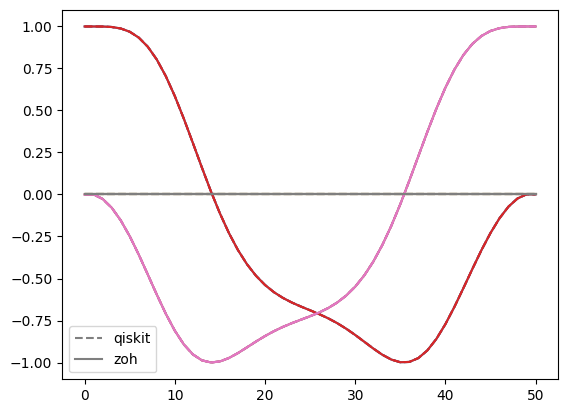

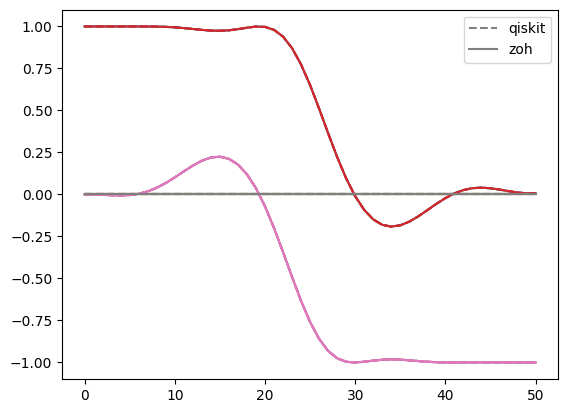

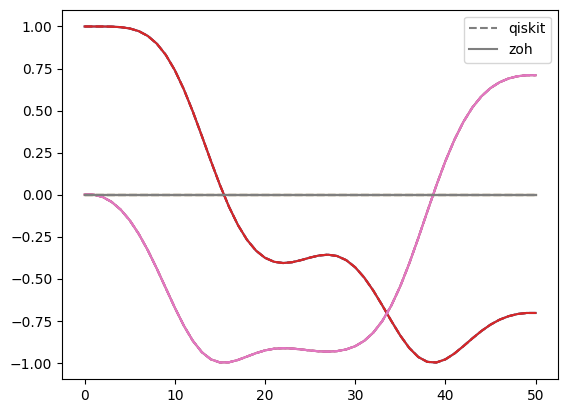

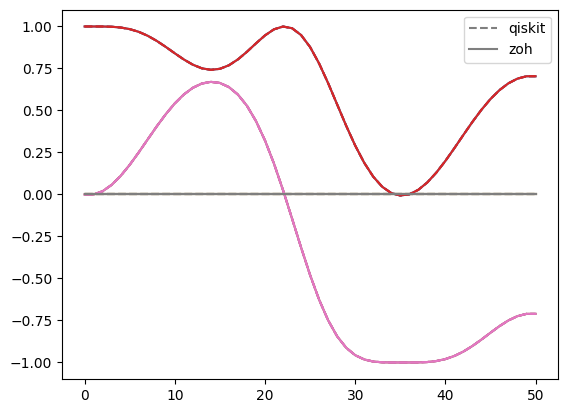

In [22]:
tab10 = plt.get_cmap("tab10")

for igate, Uts in enumerate(Gate_Uts):
    fig, ax = plt.subplots(1)
    out = np.array(get_pulse_unitary(gates[igate], n_steps, dt, solver))
    iso_vec_Uts = operator_to_iso_vec(Uts)
    iso_vec_out = operator_to_iso_vec(out)
    for i, (row_out, row_Uts) in enumerate(zip(iso_vec_out, iso_vec_Uts)):
        leg1 = ax.plot(row_out, ls='--', c=tab10(i))
        leg2 = ax.plot(row_Uts, c=tab10(i))
        ax.legend([leg1[0], leg2[0]], ["qiskit", "zoh"])

## Normalize to one and two rotations

In [23]:
expected_list = [XGate(), XGate(), SXGate(), SXGate()]

for i, gate in enumerate(gates):
    # print("Output unitary:")
    out = get_pulse_unitary(gate, n_steps, dt, solver)[-1]
    # print(np.round(out.data, 5))

    # print("Expected unitary:")
    expected = qk_qi.Operator(expected_list[i])
    # print(np.round(expected.data, 5))

    print("Fidelity: ", qk_qi.process_fidelity(expected, out, require_cp=False, require_tp=False))

Fidelity:  0.9999988342802488
Fidelity:  0.9999537472389898
Fidelity:  0.9999815532759874
Fidelity:  0.9999762550634187


In [24]:
expected_list = [XGate(), XGate(), SXGate(), SXGate()]
expected_angle = [3 * np.pi / 2, np.pi / 2, 5 * np.pi / 4, np.pi / 4]

for i, gate in enumerate(gates):
    # print("Output unitary:")
    out = get_pulse_unitary(gate, n_steps, dt, solver, expected=expected_angle[i])[-1]
    # print(np.round(out.data, 5))

    # print("Expected unitary:")
    expected = qk_qi.Operator(expected_list[i])
    # print(np.round(expected.data, 5))

    print("Fidelity: ", qk_qi.process_fidelity(expected, out, require_cp=False, require_tp=False))

Fidelity:  0.9999988342802488
Fidelity:  0.9999537472389898
Fidelity:  0.9999815532759874
Fidelity:  0.9999762550634187


## Normalize to one rotation

In [25]:
expected_list = [XGate(), XGate(), SXGate(), SXGate()]
expected_angle = [np.pi / 2, np.pi / 2, np.pi / 4, np.pi / 4]

for i, gate in enumerate(gates):
    # print("Output unitary:")
    out = get_pulse_unitary(gate, 50, dt, solver, expected=expected_angle[i])[-1]
    # print(np.round(out.data, 5))

    # print("Expected unitary:")
    expected = qk_qi.Operator(expected_list[i])
    # print(np.round(expected.data, 5))

    print("Fidelity: ", qk_qi.process_fidelity(expected, out, require_cp=False, require_tp=False))

Fidelity:  0.9999988342802488
Fidelity:  0.9999537472389898
Fidelity:  0.9999815532759874
Fidelity:  0.9999762550634187


We can also construct a schedule with all the gates and measure its fidelity.

In [26]:
with qk.pulse.build() as all_pulses_moment:
    channel = qk.pulse.DriveChannel(0)
    for pulse_array, expected in zip(gates, expected_angle):
        normalization = np.trapz(pulse_array, dx=dt) / expected
        pulse_array = pulse_array / normalization
        pulse = qk.pulse.Waveform(pulse_array, limit_amplitude=False)
        qk.pulse.play(pulse, channel)

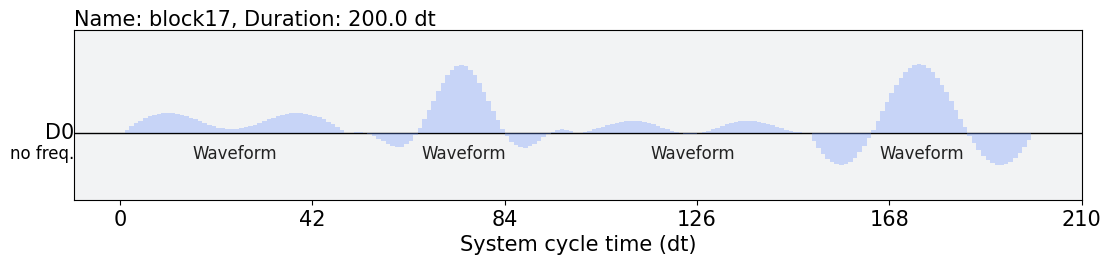

In [33]:
all_pulses_moment.draw()

In [37]:
U0 = ps.qiskit_identity_operator(1)
sol = solver.solve(
    t_span=[0.0, 200],
    y0=U0,
    signals=all_pulses_moment,
    atol=1e-8,
    rtol=1e-8,
    method="jax_odeint",
)
out = sol.y[-1]

In [29]:
out.data

array([[-5.83786193e-05+0.j        ,  0.00000000e+00+0.99999999j],
       [ 0.00000000e+00+0.99999999j, -5.83786193e-05+0.j        ]])

In [30]:
qk_qi.process_fidelity(out, qk_qi.Operator(XGate()), require_cp=False, require_tp=False)

0.9999999754789358